In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob 
import tensorflow as tf
import PIL
from PIL import ImageDraw

from tensorflow.keras import models
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense,Flatten, Activation, BatchNormalization,Input,Add,ZeroPadding2D,AveragePooling2D,GlobalMaxPooling2D,MaxPool2D
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet_v2 import ResNet152V2,ResNet50V2, preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions



In [2]:
train_path = 'D:\\빅데이터기반지능형서비스개발\\07기업요구사항기반의문제해결pjt\\data\\Train_data\\hairloss'
valid_path = 'D:\\빅데이터기반지능형서비스개발\\07기업요구사항기반의문제해결pjt\\data\\Validation\\hairloss'
test_path = 'D:\\빅데이터기반지능형서비스개발\\07기업요구사항기반의문제해결pjt\\data\\Test\\hairloss'

In [3]:
def preprocess(x):
    ii=x
    ii[:,:,0]= 1.0 * (ii[:,:,0] > 75)
    ii[:,:,1]= 1.0 * (ii[:,:,1] > 125)
    ii[:,:,2]= 1.0 * (ii[:,:,2] > 180)
    x=ii
    return x
    

In [14]:
labels=pd.Series(os.listdir(train_path))
labels=labels.sort_values()
labels=labels.to_list()

image_height = 224  # 이미지 높이
image_width = 224   # 이미지 넓이
batch_size = 32     # batch size
epochs  = 20  # trining 횟수
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
#train_datagen = ImageDataGenerator(preprocessing_function=preprocess)
#val_datagen = ImageDataGenerator(preprocessing_function=preprocess)
#test_datagen = ImageDataGenerator(preprocessing_function=preprocess)
                                  
# train_datagen 인스턴스를 통해 train dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 training_set 객체를 생성.
train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size=(image_width, image_height),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')


# val_datagen 인스턴스를 통해 test dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 test_set 객체를 생성.
test_set = test_datagen.flow_from_directory(test_path,                                            
                                            target_size=(image_width, image_height),
                                            batch_size=batch_size,
                                            class_mode='categorical')

#val_datagen 인스턴스를 통해 val dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 val_set 객체를 생성.
val_set = val_datagen.flow_from_directory(valid_path,                                        
                                           target_size=(image_width, image_height),
                                           batch_size=batch_size,
                                           class_mode='categorical')

Found 63270 images belonging to 4 classes.
Found 2643 images belonging to 4 classes.
Found 7514 images belonging to 4 classes.


In [31]:
train_set[1][1]

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

In [15]:
class_path = glob.glob(train_path + '/*')
print(f'train set의 이미지 클래스: {train_set.class_indices}')
print(f'test set의 이미지 클래스: {test_set.class_indices}')
print(f'validation set의 이미지 클래스: {val_set.class_indices}')
classNum = []
fileNum = []
for path in class_path :
    fileNum.append(len(glob.glob(path + '/*')))
    classNum.append(int(path.split('_')[-1]))

label_dic = dict(zip(classNum, fileNum))
label_dic

train set의 이미지 클래스: {'hairloss_0': 0, 'hairloss_1': 1, 'hairloss_2': 2, 'hairloss_3': 3}
test set의 이미지 클래스: {'hairloss_0': 0, 'hairloss_1': 1, 'hairloss_2': 2, 'hairloss_3': 3}
validation set의 이미지 클래스: {'hairloss_0': 0, 'hairloss_1': 1, 'hairloss_2': 2, 'hairloss_3': 3}


{0: 15651, 1: 20669, 2: 10992, 3: 15958}

In [16]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#model.add(Conv2D(128, (3, 3), activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax')) # 2 because we have cat and dog classes
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 54, 54, 64)       

In [24]:
from collections import Counter
counter = Counter(train_set.classes)
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images/10 for class_id, num_images in counter.items()}                     
class_weights

{0: 0.13206184908312568, 1: 0.1, 2: 0.1880367540029112, 3: 0.12952124326356687}

In [25]:
opt = tf.keras.optimizers.Adam(learning_rate= 0.0001)

# 모델 학습시 가장 최신의 최고 모델을 저장하는 인스턴스를 정의
modelCheckpoint = ModelCheckpoint('logs/hairloss_custom.h5', save_best_only=True)

# 모델 학습시 정확도를 모니터링하여 조기에 학습을 종료시키는 인스턴스 정의
monitor_val_acc = EarlyStopping(monitor='val_acc', patience=3)

# callback 정의
callbacks= [modelCheckpoint,monitor_val_acc]

model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['acc'])

history =model.fit(train_set,
                    epochs=epochs,
                    validation_data=val_set,
                    callbacks=callbacks
                   )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1978 steps, validate for 235 steps
Epoch 1/20
1978/1978 [==============================] - 157s 80ms/step - loss: 0.6077 - acc: 0.7494 - val_loss: 0.8609 - val_acc: 0.6731
Epoch 2/20
1978/1978 [==============================] - 157s 79ms/step - loss: 0.5748 - acc: 0.7622 - val_loss: 1.2610 - val_acc: 0.6053
Epoch 3/20
1978/1978 [==============================] - 156s 79ms/step - loss: 0.5559 - acc: 0.7729 - val_loss: 0.8696 - val_acc: 0.6417
Epoch 4/20
1978/1978 [==============================] - 156s 79ms/step - loss: 0.5284 - acc: 0.7816 - val_loss: 1.2707 - val_acc: 0.5789


In [26]:
(test_loss, test_accuracy) = model.evaluate(test_set, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy*100)

  ...
    to  
  ['...']
83/83 [==============================] - 3s 35ms/step - loss: 0.8418 - acc: 0.7382
Test loss: 0.8418174669685135
Test accuracy: 73.81762862205505


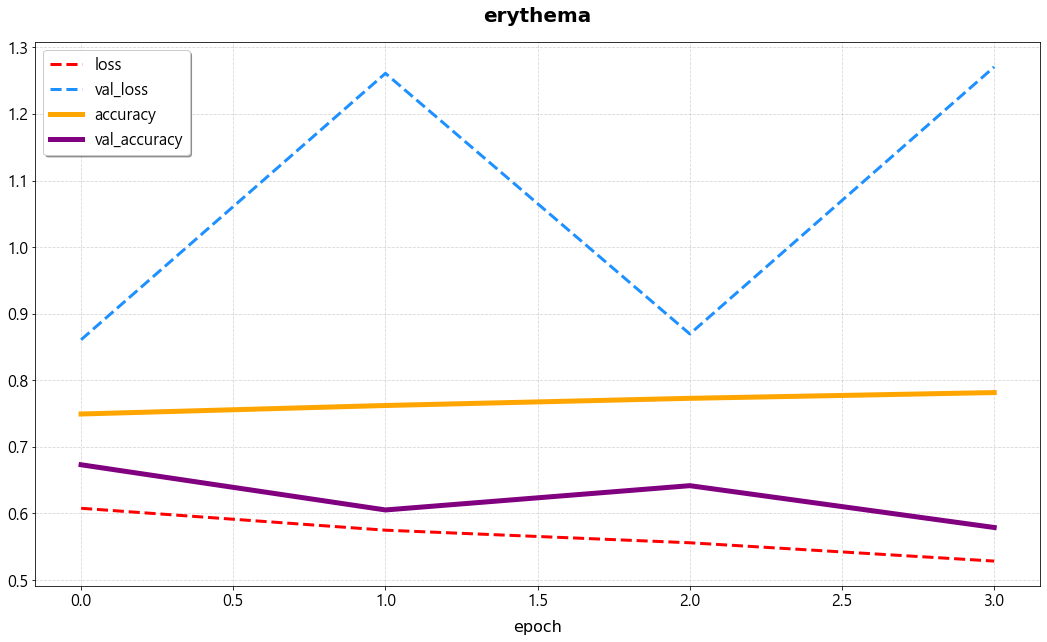

In [27]:
font1 = {'family': 'DejaVu Sans',
         'weight': 'bold',
         'size': 20
         }

font2 = {'family': 'DejaVu Sans',
         'size': 16
         }   

plt.figure(figsize=(18,10))

plt.plot(history.history['loss'], '--', c = 'red', label = 'loss', linewidth = 3)
plt.plot(history.history['val_loss'], '--', c = 'dodgerblue', label = 'val_loss', linewidth = 3)
plt.plot(history.history['acc'], c='orange',label = 'accuracy', linewidth = 5)
plt.plot(history.history['val_acc'],c='purple',label = 'val_accuracy', linewidth = 5)


plt.legend(['loss', 'val_loss','accuracy','val_accuracy'],shadow = True, loc='best',fontsize = 16)
plt.title('erythema', fontdict=font1, pad = 20)
plt.xlabel('epoch', fontdict=font2, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, alpha=0.5, linestyle='--')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model=load_model('logs/hairloss_custom.h5')

In [ ]:
dd = model.evaluate_generator(test_set,32)
dd

---

---

In [5]:
from tensorflow.keras.models import load_model
model=load_model('logs/hairloss.h5')

In [28]:
dd = model.evaluate_generator(test_set,32)
dd

  ...
    to  
  ['...']


[0.807028517127037, 0.7402344]

<AxesSubplot:>

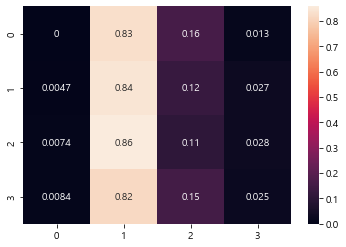

In [29]:
test_set.reset()
Y_pred = model.predict_generator(test_set)#validation_generator.n // validation_generator.batch_size+1)
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(Y_pred, axis=1) 

cm=confusion_matrix(test_set.classes, y_pred)
tot=np.sum(cm,axis=1)
cm1=cm/tot[:,None]
classes=['0','1','2','3']
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
df_cm = pd.DataFrame(cm1,
                     index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure()
sn.heatmap(df_cm, annot=True)

In [8]:
cm

array([[  8,  53,   6,   9],
       [ 54, 199,  30,  20],
       [ 19,  78,   8,   3],
       [ 10,  30,   4,   3]], dtype=int64)